In [1]:
import json
import os.path as osp
from PIL import Image
import torch.nn as nn
from torch.autograd import Variable
import torch
import numpy as np
from data import CreateTrgDataLoader
from model import CreateModel
import os
from options.test_options import TestOptions
import scipy.io as sio
from evaluation_multi import compute_mIoU, label_mapping, fast_hist, per_class_iu
import matplotlib.pyplot as plt
np.set_printoptions(threshold = np.inf, suppress=True)

# Detail into the Prediction, GT(after label mapping)

Num classes 19
pred shape: (1024, 2048)


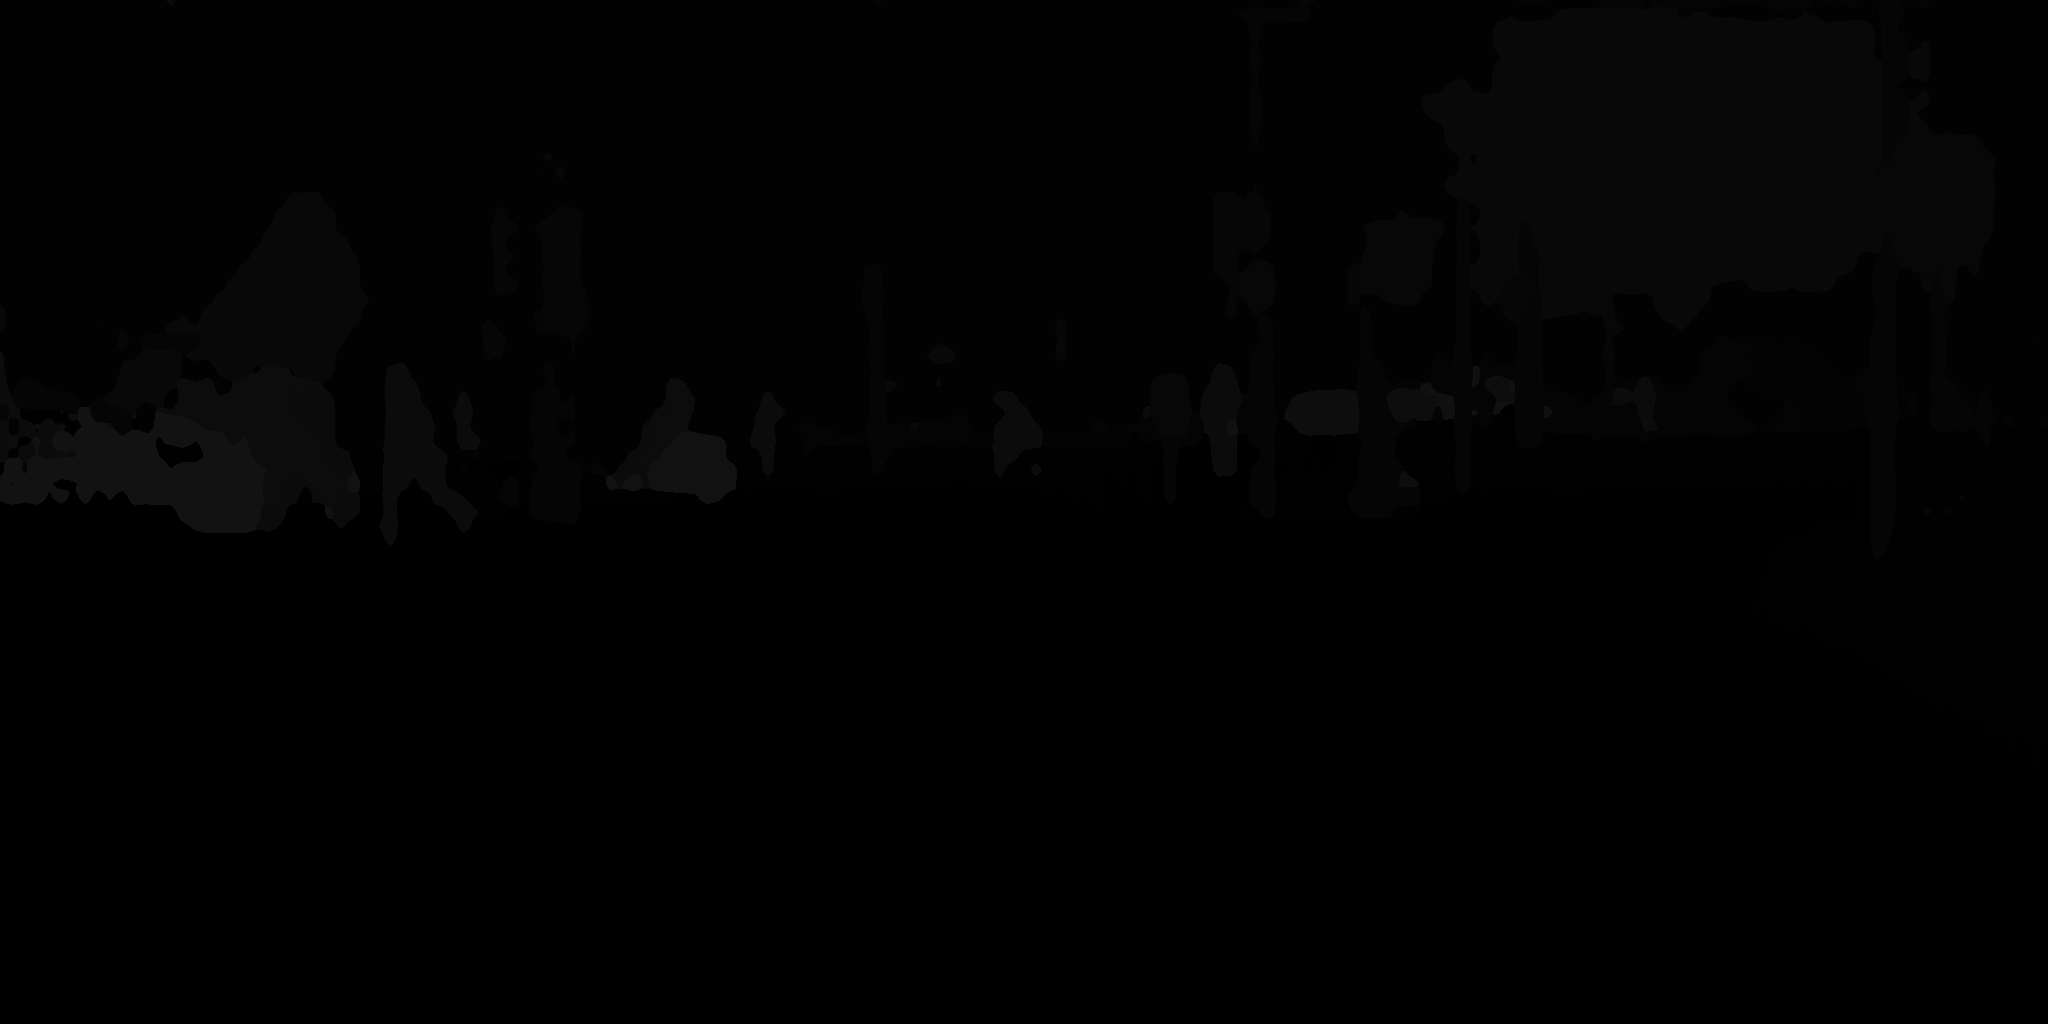

label shape: (1024, 2048)


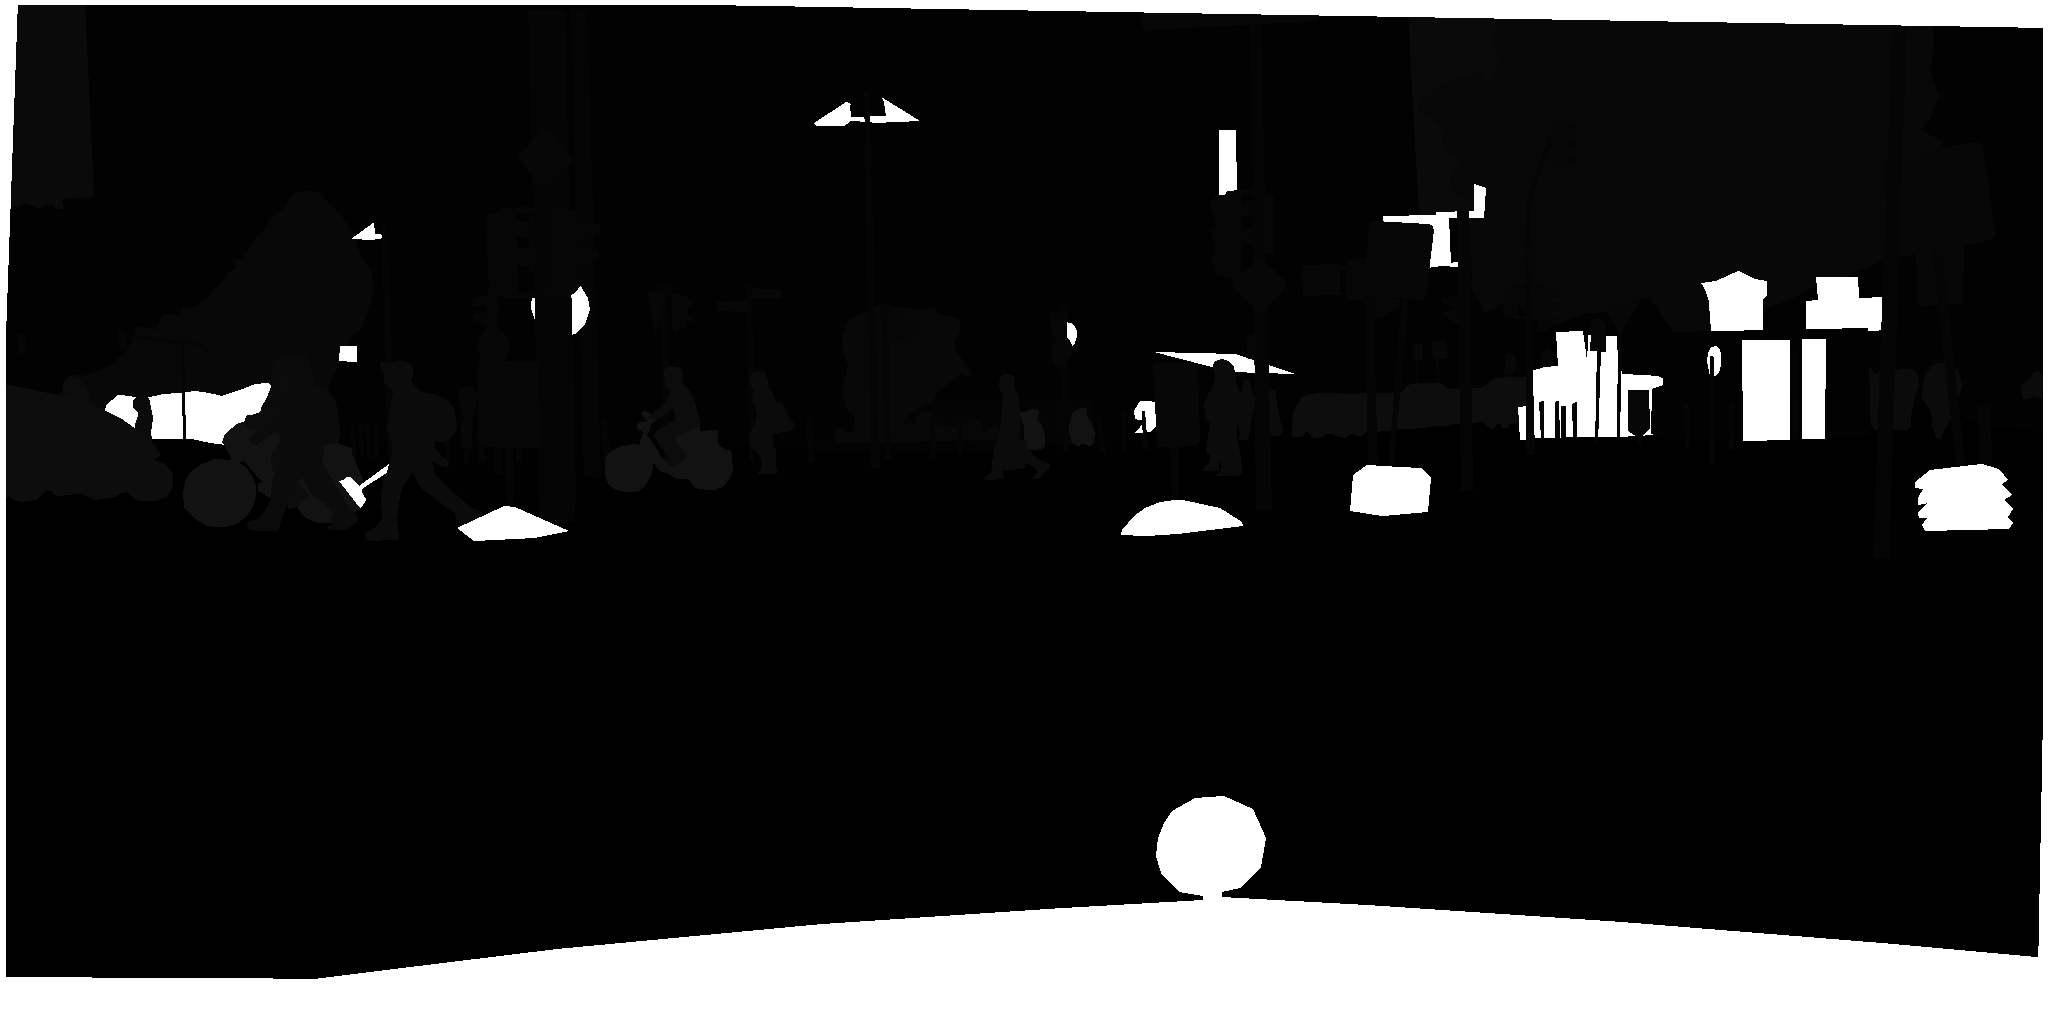

color_label shape: (1024, 2048, 4)


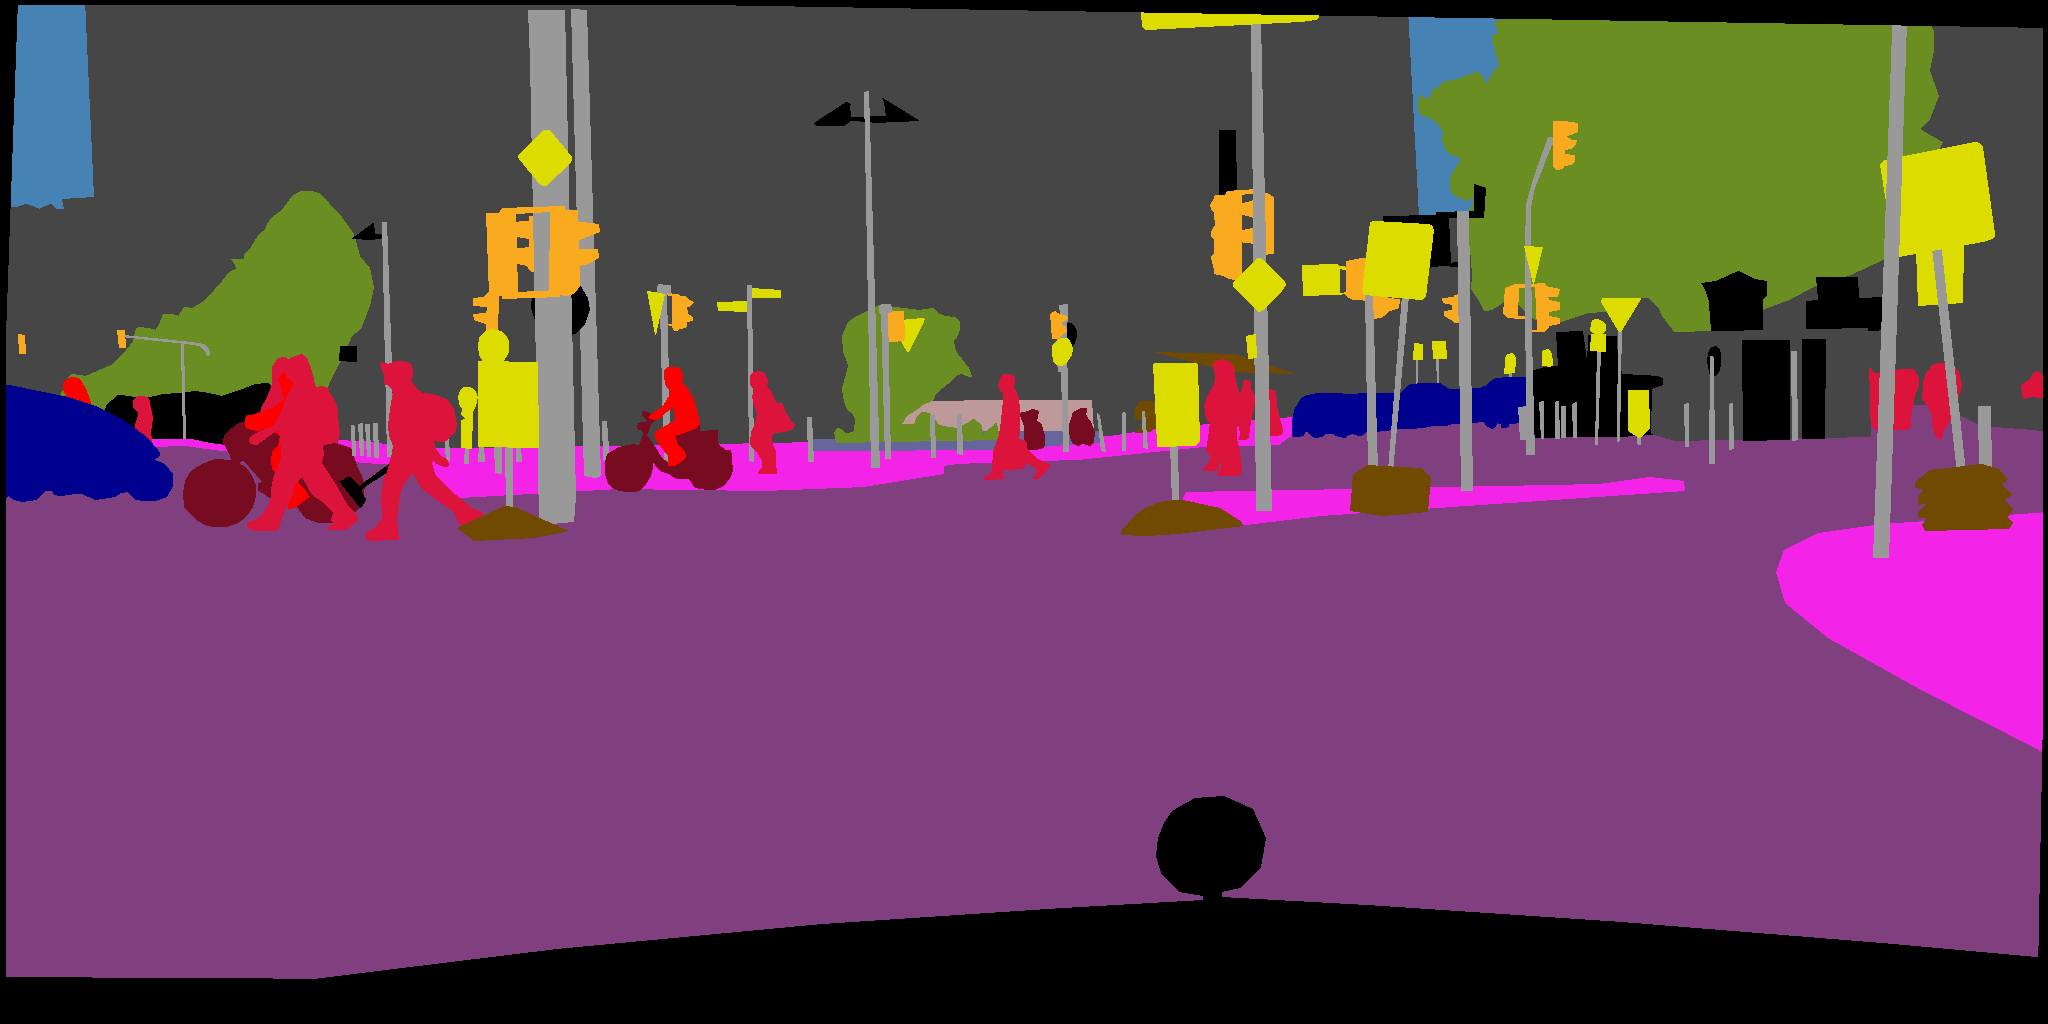

hist shape: (19, 19)
[[823879.  46194.    171.      0.    385.   3490.      0.      0.      0.
       0.      0.    468.     69.     28.      0.      0.      0.    439.
    2770.]
 [  3967.  55608.   1335.    603.    199.   1360.      0.      0.      0.
       0.      0.    454.     45.     35.      0.      0.      0.    951.
     403.]
 [     0.    839. 482046.   2463.   7632.   5408.    954.   2254.    261.
       0.      1.    956.    251.    460.      0.      0.    135.     42.
       0.]
 [     0.    569.     81.    591.    493.     78.      0.      0.      0.
       0.      0.     61.      0.      0.      0.      0.      0.      0.
       0.]
 [     0.      0.   2789.      0.    223.      0.      0.      0.      4.
       0.      0.    161.      0.      0.      0.      0.      0.      0.
       0.]
 [   406.   1894.  24202.    579.   2456.  25012.   2645.   1832.    608.
       0.      0.    396.    240.    178.      0.      0.      1.     29.
      65.]
 [     0.      0.   6188.

/environment/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [86]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

pred_dir = './results/model_paper/model1'
gt_dir = '../../data/cityscapes/gtFine/val'
devkit_dir = './dataset/cityscapes_list'

with open( osp.join(devkit_dir, 'info.json'),'r' ) as fp:
    info = json.load(fp)
num_classes = int(info['classes'])
print('Num classes', num_classes)

name_classes = np.array(info['label'], dtype=str)
mapping = np.array( info['label2train'],dtype=int )
hist = np.zeros( (num_classes, num_classes) )

image_path_list = osp.join( devkit_dir, 'val.txt')
label_path_list = osp.join( devkit_dir, 'label.txt')
gt_imgs = open(label_path_list, 'r').read().splitlines()
gt_imgs = [osp.join(gt_dir, x) for x in gt_imgs]
pred_imgs = open(image_path_list, 'r').read().splitlines()
pred_imgs = [osp.join(pred_dir, x.split('/')[-1]) for x in pred_imgs]

for ind in range(1):
    pred  = np.array(Image.open(pred_imgs[ind]))
    label = np.array(Image.open(gt_imgs[ind]))
    color = np.array(Image.open(osp.join(gt_dir, 'frankfurt/frankfurt_000001_007973_gtFine_color.png')))
    
    label = label_mapping(label, mapping)
    if len(label.flatten()) != len(pred.flatten()):
        print('Skipping: len(gt) = {:d}, len(pred) = {:d}, {:s}, {:s}'.format( len(label.flatten()), len(pred.flatten()), gt_imgs[ind], pred_imgs[ind] ))
        continue
    hist += fast_hist(label.flatten(), pred.flatten(), num_classes)
    
    print('{} {}'.format('pred shape:', pred.shape))
    Image.fromarray(pred.astype(np.uint8)).show()
    print('{} {}'.format('label shape:', label.shape))
    Image.fromarray(label.astype(np.uint8)).show()
    print('{} {}'.format('color_label shape:', color.shape))
    Image.fromarray(color.astype(np.uint8)).show()
    
    print('{} {}'.format('hist shape:', hist.shape))
    print(hist)

hist2 = np.zeros((19, 19))

for i in range(19):
    hist2[i] = hist[i]/np.sum(hist[i])

mIoUs = per_class_iu(hist)

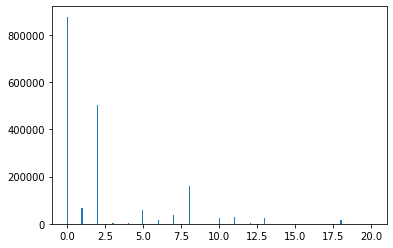

(15,)

In [87]:
plt.hist(label.flatten(), 255, range=(0,20))
plt.show()
np.nonzero(np.bincount(label.flatten()))[0].shape

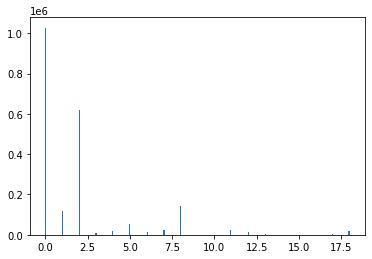

(16,)

In [88]:
plt.hist(pred.flatten(), 255)
plt.show()
np.nonzero(np.bincount(pred.flatten()))[0].shape

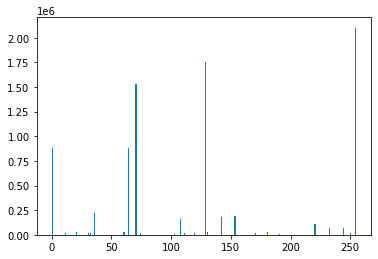

(27,)

In [89]:
plt.hist(color.flatten(), 255)
plt.show()
np.nonzero(np.bincount(color.flatten()))[0].shape

<function matplotlib.pyplot.show(close=None, block=None)>

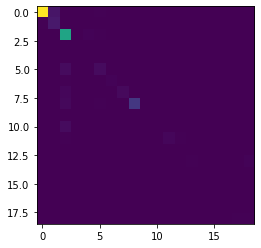

In [90]:
plt.imshow(hist)
plt.show

In [37]:
from DL_domain_adaptation.acdc import ACDC, get_train_trans
from torch.utils.data import DataLoader

# add acdc
transforms = get_train_trans(
    (0.485, 0.456, 0.406), # mean for input normalization -- commented in source code
    (0.229, 0.224, 0.225), # std for input normalization -- commented in source code
    (512,1024), # target size (rescaling)
    (512,1024), # random crop size
    0.0, # random color jitter augmentation factor
    0.0, # scale factor for random scale augmentation
    True) # random horizontal flipping

dataset = ACDC('DL_domain_adaptation/data', split="train", transforms=transforms)
# print(next(iter(dataset)))

targetloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [41]:
len(targetloader)

400

In [57]:
'DL_domain_adaptation/data'

In [62]:
for ind, batch in enumerate(targetloader):
    image, label, name = batch
    print("{}{}".format('label.shape:', label.shape))
    print("{}{}".format('iamge.shape:', image.shape))
    label = np.array(label)
    plt.hist(label.flatten(),255)
    plt.show()
    hist = np.bincount(label.flatten())
    print(hist)
    if ind==0:
        break

AttributeError: 'Tensor' object has no attribute 'train_id'

In [75]:
result = Image.open('./results/model_acdc/model1/GOPR0351_frame_000159_rgb_anon.png')
result.size

(2048, 1024)

In [ ]:
with open( osp.join('./dataset/cityscapes_list', 'info.json'),'r' ) as fp:
    info = json.load(fp)
num_classes = np.int(info['classes'])
# print('Num classes', num_classes)

name_classes = np.array(info['label'], dtype=np.str)
mapping = np.array( info['label2train'],dtype=np.int )
hist = np.zeros( (num_classes, num_classes) )

with torch.no_grad():
    for ind, batch in enumerate(dataloader):
        if index == 100: break
        if ind % 100 == 0:
            print( '%d processed' % ind )
        _, label, name = batch
        label = label_mapping(label, mapping)
        pred = outputs[ind]
        print('{}, {}'.format('Prediction:', pred.shape))
        print('{}, {}'.format('Label:', label.shape))
        if len(label.flatten()) != len(pred.flatten()):
            print('Skipping: len(gt) = {:d}, len(pred) = {:d}'.format( len(label.flatten()), len(pred.flatten())))
            continue
        hist += fast_hist(label.flatten(), pred.flatten(), num_classes)
        if ind > 0 and ind % 10 == 0:
            print("writing mIou")
            with open(restore_from+'_mIoU.txt', 'a') as f:
                f.write( '{:d} / {:d}: {:0.2f}\n'.format(ind, len(name), 100*np.mean(per_class_iu(hist))) )
            print('{:d} / {:d}: {:0.2f}'.format(ind, len(name), 100*np.mean(per_class_iu(hist))))